In [1]:
## updated 8/18/24 ##

# python version 3.6.9 #
import pandas as pd # 1.1.5
import numpy as np # 1.19.5
import matplotlib.pyplot as plt
import matplotlib # 3.3.4
import scipy.stats as st # scipy 1.5.4
from matplotlib_venn import venn3, venn3_circles
import matplotlib.ticker as ticker
import seaborn as sns

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rc('text', usetex=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('source_data/included/figure.style')


In [2]:
combined = pd.read_csv('source_data/included/fig4_CRISPRi_enrichment.txt',sep='\t',index_col=0)
for rRNA_type in ['rrf','rrl','rrs']:
    LAG = combined.loc[(combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b'))].iloc[0,0]
    to_append = combined.loc[(combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b'))].groupby('strand').mean().reset_index()
    to_append.loc[:,to_append.columns.str.contains('signif')] = np.round(to_append.loc[:,to_append.columns.str.contains('signif')])
    to_append['LAGs'] = [LAG,LAG]
    combined = combined.loc[~((combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b')))]
    combined = combined.append(to_append)
    combined = combined.reset_index().drop('index',axis=1)

In [3]:
## define replicates for each sample type
metG_lag = ['SBC210_vs_SBC205','SBC101_vs_SBC96','SBC102_vs_SBC96','SBC100_vs_SBC96','SBC192_vs_SBC191']
MG1655_lag = ['SBC131_vs_SBC126','SBC132_vs_SBC126','SBC130_vs_SBC126']
metG_lag_abx = ['SBC207_vs_SBC210','SBC208_vs_SBC210','SBC209_vs_SBC210','SBC98_vs_SBC101','SBC99_vs_SBC101']
MG1655_lag_abx = ['SBC128_vs_SBC131','SBC129_vs_SBC131']
metG_exp = ['SBC212_vs_SBC211']
MG1655_exp = ['SBC134_vs_SBC133']
hipA7_lag = ['SBC318_vs_SBC316']
hipA7_lag_abx = ['SBC317_vs_SBC318']
wt_YqgE_lag = ['SBC309_vs_SBC308','SBC313_vs_SBC312']
wt_RFP_lag = ['SBC311_vs_SBC310','SBC315_vs_SBC314']

## create dictionaries counting the number of over-represented and under-represented instances of each gene in given experiment type
classes = [metG_lag,MG1655_lag,metG_exp,MG1655_exp,metG_lag_abx,MG1655_lag_abx,hipA7_lag,hipA7_lag_abx,wt_YqgE_lag,wt_RFP_lag]
names = ['metG_lag','MG1655_lag','metG_exp','MG1655_exp','metG_lag_abx','MG1655_lag_abx','hipA7_lag','hipA7_lag_abx','wt_YqgE_lag','wt_RFP_lag']
up_dict = {}
down_dict = {}
for c,n in zip(classes,names):
    up = []
    down = []
    for comparison in c:
        if (len(up) == 0) and (len(down) == 0):
            up = (combined['signif_' + comparison] == 1).astype(int)
            down = (combined['signif_' + comparison] == -1).astype(int)
        else:
            up = up + (combined['signif_' + comparison] == 1).astype(int)
            down = down + (combined['signif_' + comparison] == -1).astype(int)
    up_dict[n] = up
    down_dict[n] = down
    
## define a function to plot CRISPRi results of each gene ##
def scatter_errorBar(LAGs_list,strand_list,plot_type='gene',sub_combined='',save=False,prefix='',ylim=0):
    for (LAGs,strand) in zip(LAGs_list,strand_list):
        fig,ax = plt.subplots(figsize=(5,5))
        colors = ['tomato','k','dodgerblue']
        classes = [metG_lag,hipA7_lag,MG1655_lag,metG_exp,MG1655_exp,metG_lag_abx,hipA7_lag_abx,MG1655_lag_abx]
        names = ['metG','hipA7','WT','metG','WT','metG','hipA7','WT']
        max_y = 0
        i = 0
        for c,name,i in zip(classes,names,range(1,len(names)+1)):
            y_list = []
            first = True
            for comparison in c:
                if plot_type == 'gene':
                    y = combined.loc[(combined['LAGs']==LAGs)&(combined['strand']==strand)]['enrichment_' + comparison]
                    signif = int(combined.loc[(combined['LAGs']==LAGs)&(combined['strand']==strand),'signif_' + comparison])
                    y_list.append(y.values[0])
                elif plot_type == 'term':
                    y = sub_combined['enrichment_' + comparison]
                    if (y>0) & (comparison in signif_up_matrix.loc[signif_up_matrix['GO'].str.contains(term)].index):
                        signif = 1
                    elif (y<0) & (comparison in signif_down_matrix.loc[signif_down_matrix['GO'].str.contains(term)].index):
                        signif = 1
                    else:
                        signif = 0
                    y_list.append(y)
                if (i>0) & (i<=3):
                    col = 0
                if (i>3) & (i<=5):
                    col = 1
                if (i>5):
                    col = 2
                if first:
                    x = i
                    first = False
                else:
                    x = np.random.normal(i, 0.05) # jitter points after the first
                ## plot each replicate - filled if significant ##
                if signif != 0:
                    ax.scatter(x,y,facecolors=colors[col],s=100,alpha=1,zorder=10,edgecolors=colors[col])
                else:
                    ax.scatter(x,y,facecolors='none',s=100,alpha=1,zorder=10,edgecolors=colors[col])
            ax.errorbar(i, np.mean(y_list), np.std(y_list), fmt='ok', lw=3,capsize=0,elinewidth=1,marker='_',mew=2,markersize=30,zorder=1)
        ax.set_xticks(np.arange(1,len(names)+1,1))
        ax.set_xticklabels(names,size=16,rotation=0,ha='center')
        ax.axvline(3.5,color='k',alpha=0.5,linewidth=0.2)
        ax.axvline(5.5,color='k',alpha=0.5,linewidth=0.2)
        ## set plot aesthetics ##
        if ylim != 0:
            ax.set_ylim(ylim)
        ax.axhline(0,color='k')
        ax.set_xlim(0.5,len(names)+0.5)
        ax.set_ylabel('log' + '$_{2}$' + '(fold-change)',size=16)
        ax.set_title(LAGs.split('=')[1],size=16)
        ax2 = ax.twiny()
        ax2.spines["bottom"].set_position(("axes", -0.125))
        ax2.tick_params('both', length=0, width=0, which='minor')
        ax2.tick_params('both', length=12,direction='in', which='major')
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.set_xticks([0.0,0.37,0.6,1])
        ax2.xaxis.set_major_formatter(ticker.NullFormatter())
        ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.165,0.495,0.83]))
        ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['lag', 'exp','lag\nabx']))
        ##
        if save:
            plt.savefig(prefix + LAGs.split('=')[1].replace(':','_') + '_scatter.pdf')


413
SpearmanrResult(correlation=0.8445389073487893, pvalue=1.5343457880548916e-113)


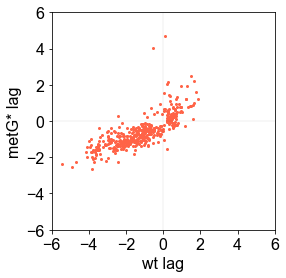

In [4]:
## find significant lag-affecting genes
## drop duplicate LAGs (anti-sense + sense) based on which is significant in most replicates then which has higher enrichment (absolute value)

## select genes significant in at least 2 metG* or wt replicates
to_include = ((up_dict['metG_lag']>=2) & (up_dict['metG_lag_abx']==0))| (down_dict['metG_lag']>=2) | ((up_dict['MG1655_lag']>=2) & (up_dict['MG1655_lag_abx']==0)) | (down_dict['MG1655_lag']>=2)

condition_set = to_include
temp = combined.copy()
temp['counts'] = (temp.loc[:,['signif_' + c for c in metG_lag]]!=0).sum(axis=1)
temp['mean'] = abs((temp.loc[:,['enrichment_' + c for c in metG_lag]]).mean(axis=1))
LAGs_list = temp.sort_values(['counts','mean'],ascending=False).drop_duplicates(subset='LAGs',keep='first')['LAGs']
LAGs_list = LAGs_list.reindex(combined.loc[condition_set].index).dropna()

fig,ax = plt.subplots(figsize=(4,4))

y = combined.loc[LAGs_list.index,['enrichment_' + c for c in metG_lag]].mean(axis=1)
x = combined.loc[y.index,['enrichment_' + c for c in MG1655_lag]].mean(axis=1)
ax.scatter(x,y,s=4,color='tomato')

ax.set_xlim(-6,5)
ax.set_ylim(-6,5)
ax.axhline(0,color='k',alpha=0.2,linewidth=0.3)
ax.axvline(0,color='k',alpha=0.2,linewidth=0.3)

ax.set_ylabel('metG* lag')
ax.set_xlabel('wt lag')
ax.set_xticks([-6,-4,-2,0,2,4,6])
ax.set_yticks([-6,-4,-2,0,2,4,6])

print(len(LAGs_list))
print(st.spearmanr(x,y))

plt.savefig('figures/fig4b.pdf')

In [5]:
source_data = pd.DataFrame([combined.loc[LAGs_list.index,'LAGs'],combined.loc[LAGs_list.index,'strand'],x,y],index=['gene','strand','wt_lag','metG_lag']).transpose()
source_data.to_csv('source_data/source_tables/fig4b.csv',index=False)

215
SpearmanrResult(correlation=0.8740841362988723, pvalue=1.0131433348730133e-68)


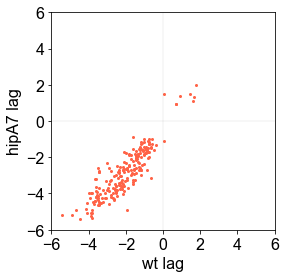

In [6]:
hip_table = combined[['LAGs','strand','enrichment_SBC318_vs_SBC316','n_positions_SBC318_vs_SBC316','p_val_SBC318_vs_SBC316','signif_SBC318_vs_SBC316']]
hip_table = hip_table.loc[hip_table.sum(axis=1)>0]
hip_len = len(hip_table)

## select genes significant in hipA7 library

to_include = ((up_dict['hipA7_lag']>=1) & (up_dict['hipA7_lag_abx']==0))| (down_dict['hipA7_lag']>=1)

condition_set = to_include
temp = combined.copy()
temp['counts'] = (temp.loc[:,['signif_' + c for c in hipA7_lag]]!=0).sum(axis=1)
temp['mean'] = abs((temp.loc[:,['enrichment_' + c for c in hipA7_lag]]).mean(axis=1))
LAGs_list = temp.sort_values(['counts','mean'],ascending=False).drop_duplicates(subset='LAGs',keep='first')['LAGs']

## limit to highly significant - bonferroni-corrected p-value <0.05
LAGs_list = LAGs_list.reindex(combined.loc[condition_set & (combined['p_val_SBC318_vs_SBC316']<(0.05/hip_len)) & (combined['signif_SBC318_vs_SBC316']!=0)].index).dropna()

fig,ax = plt.subplots(figsize=(4,4))
y = combined.loc[LAGs_list.index,['enrichment_' + c for c in hipA7_lag]].mean(axis=1)
x = combined.loc[y.index,['enrichment_' + c for c in MG1655_lag]].mean(axis=1)
ax.scatter(x,y,s=4,color='tomato')

ax.set_xlim(-6,5)
ax.set_ylim(-6,5)
ax.axhline(0,color='k',alpha=0.2,linewidth=0.3)
ax.axvline(0,color='k',alpha=0.2,linewidth=0.3)

ax.set_ylabel('hipA7 lag')
ax.set_xlabel('wt lag')
ax.set_xticks([-6,-4,-2,0,2,4,6])
ax.set_yticks([-6,-4,-2,0,2,4,6])

print(len(LAGs_list))
print(st.spearmanr(x,y))

plt.savefig('figures/fig4c.pdf')

In [7]:
source_data = pd.DataFrame([combined.loc[LAGs_list.index,'LAGs'],combined.loc[LAGs_list.index,'strand'],x,y],index=['gene','strand','wt_lag','hipA7_lag']).transpose()
source_data.to_csv('source_data/source_tables/fig4c.csv',index=False)


In [8]:
## find top metG hits (significant in all 5 replicates)
metG_lag_up_top = (up_dict['metG_lag']>=5)
metG_exp_not_up = (up_dict['metG_exp']==0)
metG_abx_not_up = (up_dict['metG_lag_abx']==0)
condition_set = metG_lag_up_top & metG_exp_not_up & metG_abx_not_up

temp = combined.copy()
temp['counts'] = (temp.loc[:,['signif_' + c for c in metG_lag]]!=0).sum(axis=1)
temp['mean'] = abs((temp.loc[:,['enrichment_' + c for c in metG_lag]]).mean(axis=1))
top_LAGs = temp.sort_values(['counts','mean'],ascending=False).drop_duplicates(subset='LAGs',keep='first')
top_LAGs = top_LAGs.reindex(combined.loc[condition_set].index).dropna().sort_values('mean',ascending=False)
top_LAGs_fig4 = top_LAGs.loc[top_LAGs['LAGs'].str.contains('lon|yqgE|rpoH|sucA')]

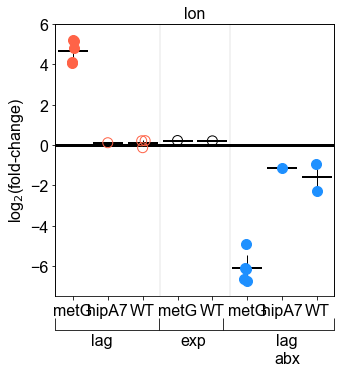

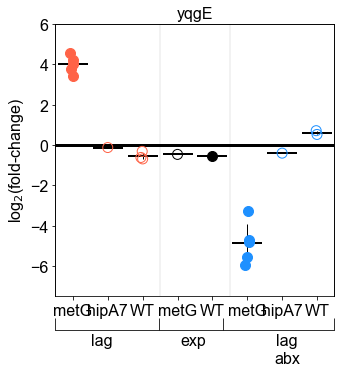

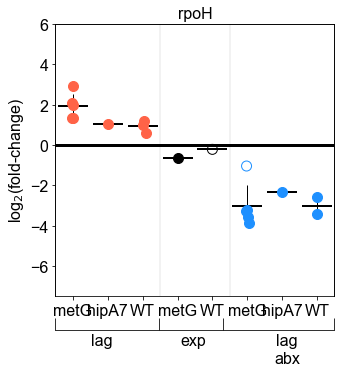

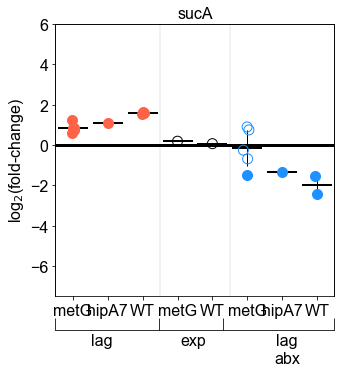

In [9]:
scatter_errorBar(top_LAGs_fig4['LAGs'],top_LAGs_fig4['strand'],plot_type='gene',sub_combined='',save=True,prefix='figures/fig4d_',ylim=(-7.5,6))


In [10]:
## 4e source data
## merge data for metG* and hipA7 in loop; all vs. cells in tetracycline (persister cluster only)
FDR=0.1
merged = pd.DataFrame()
for id1 in ['metG','hipA7']:
    filename = 'source_data/generated/' + id1 + '_vs_tet_markers_for_fig3.txt' # saved in fig3_persister_only.R
    table = pd.read_csv(filename,sep='\t',index_col=0)
    table.index = table['Row.names']
    table = table.drop('Row.names',axis=1)
    table['less'] = -table['less']
    signed_p = []
    for h,l in zip(table['greater'],table['less']):
        if abs(h)<=abs(l):
            signed_p.append(h + (10**-300))
        elif abs(l)<abs(h):
            signed_p.append(l - (10**-300))
        else:
            print('error')
    table['signed_p'] = signed_p
    table['fixed_signif'] = (abs(table['signed_p']).sort_values()<FDR*np.arange(1,len(table)+1)/len(table)).astype(int)
    table['fixed_signif'] = (table['fixed_signif'] * (table['signed_p']/abs(table['signed_p']))).astype(int)
    table.columns = table.columns + '_' + id1
    merged = merged.merge(pd.DataFrame(table[['logFC_'+id1,'signed_p_'+id1,'fixed_signif_'+id1]]),left_index=True,right_index=True,how='outer')
merged = merged.fillna(0)

merged.loc[['lon','yqgE','rpoH','sucA']]

,logFC_metG,signed_p_metG,fixed_signif_metG,logFC_hipA7,signed_p_hipA7,fixed_signif_hipA7
Row.names,,,,,,
lon,0.591458,0.000002,1.0,-0.317594,-6.674955e-01,0.0
yqgE,0.870106,0.003758,1.0,-0.045924,2.827367e-01,0.0
rpoH,0.579625,0.001612,1.0,0.692601,4.815986e-05,1.0
sucA,2.535054,0.000008,1.0,3.127675,1.156044e-07,1.0
